# Goal: Can we predict the price of a home given certain parameters?
#### By: Joshua Ko
Whether J.P. Morgan is buying or selling a property, pricing will either make or break a decision to buy or sell a home. As investors wish to maximize their profits, if they are too unreasonable with their price, they will not find a buyer. The objective is to mathmatically and statistically determine the appropriate price of a home given certain conditions so that J.P. Morgan can maximize profits and minimize losses. We will be investigating the homes in King County, Seattle. As the results may not be identical to other locations, the methodology should be analogous.

# Import libraries and load dataset

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, StrMethodFormatter

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

Load the dataset and investigate its values by using `.describe`.

In [2]:
df = pd.read_csv("data/kc_house_data.csv", index_col=0)
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


By observing the data, we see a problem with `sqft_living`. The minimum value of `sqft_living` is 3 which is clearly an error as it is not a viable area of living. Another problem is the location of some of the homes. The data includes `lat` and `long` that are outside the county. These data should be removed in the cleaning step.

# Cleaning the dataset
We should clean the dataset as keeping improper data can result in a poor model. Even if the excluded data somehow lowers the correlation between two variables, it will still return a more representive model of the dataset. As we have seen in `df.describe()` we can remove small values in `sqft_living` and accepting a certain range of values for `lat` and `long`.

In [3]:
#Removing data that is not located in Kings County
df = df.drop(df[(df.lat < 47) | (df.lat > 48)].index)
df = df.drop(df[(df.long < -123) | (df.long > -120)].index)

#Removing data that had a small sqft_living value. An arbitrary value of 100 was choosen
df = df.drop(df[(df.sqft_living) < 100].index)
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.922600e+04,29226.000000,29226.000000,29226.000000,2.922600e+04,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000
mean,1.112497e+06,3.435229,2.331948,2130.781222,1.718798e+04,1.516697,1825.895196,480.695237,336.326216,216.331280,1973.855540,93.812427,47.543087,-122.214206
std,8.953861e+05,0.978746,0.895753,977.251199,6.124692e+04,0.548202,880.709571,585.959029,286.214143,246.721313,31.676635,422.720060,0.146283,0.143620
min,2.736000e+04,0.000000,0.000000,100.000000,4.020000e+02,1.000000,100.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.000860,-122.526650
25%,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.430081,-122.328324
50%,8.670000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000,47.557643,-122.234133
75%,1.310000e+06,4.000000,3.000000,2640.000000,1.078000e+04,2.000000,2290.000000,960.000000,510.750000,310.000000,2001.000000,0.000000,47.672004,-122.127488
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.876700,-121.163960


We will also create a new column, `total rooms`, that combines `bedrooms` and `bathrooms`. This column will be used later when we group the data according to the number of rooms in a home. We can then see what number of rooms will return the most optimal correlation with the prices of homes.

In [4]:
df['price'].describe()

count    2.922600e+04
mean     1.112497e+06
std      8.953861e+05
min      2.736000e+04
25%      6.450000e+05
50%      8.670000e+05
75%      1.310000e+06
max      3.075000e+07
Name: price, dtype: float64

In [5]:
df["total rooms"] = df.bedrooms + df.bathrooms

Once the data is cleaned and the new column (`total rooms`) is made, we can see which variables are most correlated to `price`.

Although the `price` is moderately correlated to `sqft_living`, the two variables have the highest correlation. So we can create our linear model with our independent variable as `sqft_living` and our dependent variable as `price`.

## Finding outliers

Before we create a linear model, we need to determine the outliers of the data in hopes of obtaining a greater correlation value. A function for calculating the outlier is coded below:

In [6]:
def outlier(dataframe):
    #The outlier can be found by using the standard deviation or quartiles. We will be using the quartile method.
    q1 = np.quantile(dataframe, 0.25)
    q3 = np.quantile(dataframe, 0.75) 
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    outliers = dataframe[(dataframe<lower_bound) | (dataframe>upper_bound)]
    print("Lower bound: ", lower_bound, "\n" "Upper bound: ", upper_bound)

In [7]:
outlier(df["price"])

Lower bound:  -352500.0 
Upper bound:  2307500.0


In [8]:
outlier(df["sqft_living"])

Lower bound:  -360.0 
Upper bound:  4440.0


We can ignore the lower bound as a negative price does not make sense but we can exclude all the prices that are above `2307500.0`.

In [9]:
df_no_outliers = df.drop(df[(df.price > 2307500.0)].index)

#checking the change in correlations
df_no_outliers.corr()["price"]

price            1.000000
bedrooms         0.314782
bathrooms        0.438810
sqft_living      0.567144
sqft_lot         0.074442
floors           0.221466
sqft_above       0.480655
sqft_basement    0.204113
sqft_garage      0.236379
sqft_patio       0.248973
yr_built         0.090083
yr_renovated     0.053474
lat              0.426918
long             0.131733
total rooms      0.419407
Name: price, dtype: float64

After removing the outliers, the correlation value of `sqft_living` has decreased. This makes the outliers influential and therefore was lefted in the dataset.

# Housing Market
Understanding the housing market is important in selling/purchasing a home. We can observe how the prices of homes change by organizing the data by the date purchased/sold. By looking at the changes of price with respect to time, we can see the trajectory of prices and hopefully determine when to sell or buy.

We can create a null hypothesis and alternative hypothesis and perform a z-test to see if the null hypothesis can be rejected with statistical significance.

$H_0\text{: The market shows no significant change as we go through the fiscal quarters.}$

$H_a\text{: The market demonstrates notable change for each passing fiscal quarter.}$
___

We can test our hypothesis by reorganizing our data according to their fiscal quarters. By observing the format of the date, we can change the datatype and the format of the date in order to divide the dataframe accordingly.

In [10]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

#check if the date is changed
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,total rooms
id,,,,,,,,,,,,,,,,,,,,,
7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,5.0
8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,7.5
1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,8.0


Now we can create new datasets by putting the data into their corresponding fiscal quarters.

In [11]:
q1_2021 = df.loc[(df["date"] >= "2021-01-01") & (df["date"] <= "2021-03-31")]
q2_2021 = df.loc[(df["date"] >= "2021-04-01") & (df["date"] <= "2021-06-30")]
q3_2021 = df.loc[(df["date"] >= "2021-07-01") & (df["date"] <= "2021-09-30")]
q4_2021 = df.loc[(df["date"] >= "2021-10-01") & (df["date"] <= "2021-12-31")]

q1_2022 = df.loc[(df["date"] >= "2022-01-01") & (df["date"] <= "2022-03-31")]
q2_2022 = df.loc[(df["date"] >= "2022-04-01") & (df["date"] <= "2022-06-30")]
q3_2022 = df.loc[(df["date"] >= "2022-07-01") & (df["date"] <= "2022-09-30")]
q4_2022 = df.loc[(df["date"] >= "2022-10-01") & (df["date"] <= "2022-12-31")]

Upon investigation, `q1_2021`, `q3_2022`, and `q4_2022` had no values and therefore those dataframes will be omitted for the rest of the procedure.

## Calculating Z-Scores

We will be performing a z-test due to the high number of samples. However, the data must be normally distributed. This can be done by taking the __log__ or __square root__ of the data.

A function that returns a distribution plot is made. We can then determine if it is normally distributed; if it is not we can alter the values of the price.

In [12]:
def distribution(df):
    sns.set(rc={'figure.figsize':(10,5)})
    sns.set_style('white')
    return sns.histplot(df, kde=True, bins=100);

Let's look at the distribution of prices in the second quarter of 2021.

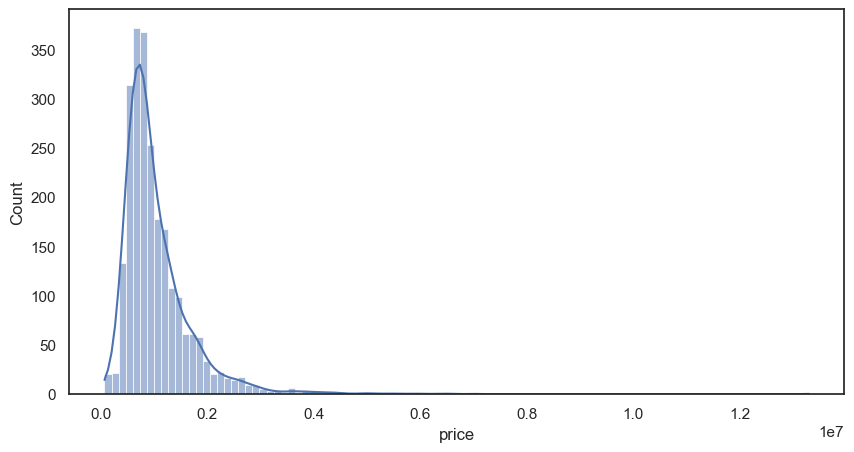

In [13]:
distribution(q2_2021["price"]);

Because the data is skewed to the right, we can fix this by taking the `log` of the data values.

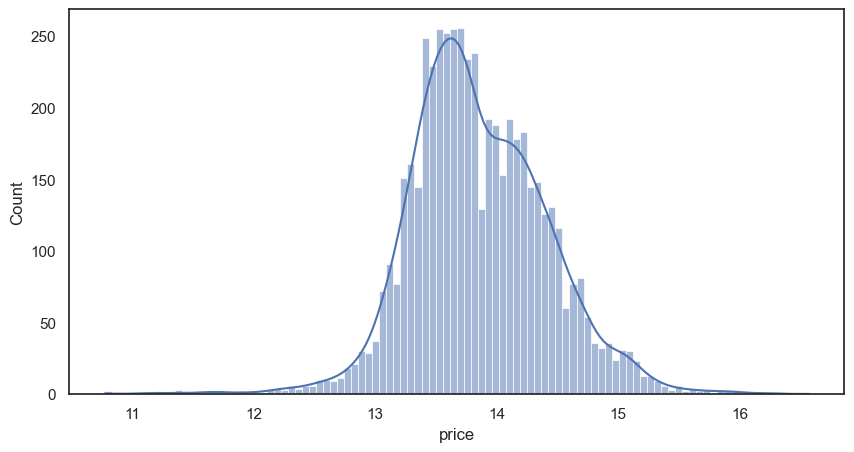

In [14]:
distribution(np.log(q2_2022["price"]));

Taking the log of the values returned a normal distribution. We can therefore take the log of the prices for all fiscal quarters.
### Creating a table for z-score
Once the data is normally distributed, a new dataset with the means, standard deviation, number of samples, and the Z-value is created for each fiscal quarter.

We can calculate the average of the log of the prices of each quarter and store them in a list:

In [15]:
quarters = [["Q2 2021", np.log(q2_2021["price"]).mean()],
            ["Q3 2021", np.log(q3_2021["price"]).mean()],
            ["Q4 2021", np.log(q4_2021["price"]).mean()],
            ["Q1 2022", np.log(q1_2022["price"]).mean()],
            ["Q2 2022", np.log(q2_2022["price"]).mean()]]

A dataframe with two columns, `Quarters` and `Average Log(Price)`, can be created by running the list `quarters` in `pd.DataFrame()`:

In [16]:
quarter_df = pd.DataFrame(quarters, columns=["Quarters", "Average Log(Price)"])

We can add two more columns: `STD` (standard deviation) and `Samples` (number of samples).

In [17]:
#Use numpy to calculate standard deviation and store the values in a new column
quarter_df["STD"] = [np.log(q2_2021["price"]).std(),
                     np.log(q3_2021["price"]).std(),
                     np.log(q4_2021["price"]).std(),
                     np.log(q1_2022["price"]).std(),
                     np.log(q2_2022["price"]).std()]

#Get the number of samples in each dataframe by taking the len() of the dataframe
quarter_df["Samples"] = [len(q2_2021),
                         len(q3_2021),
                         len(q4_2021),
                         len(q1_2022),
                         len(q2_2022)]

To calculate the z-score we can use this formula:
# $$Z = \frac{\bar{x}-\mu}{\frac{\sigma}{\sqrt{n}}}$$
$\bar{x}$ = sample mean that can be calculated by taking a sample from the dataset.
<br>$\mu$ = mean of the population
<br>$\sigma$ = standard deviation of the population
<br>n = number of data in sample

The formula to calculate the z-score is translated to a function:

In [18]:
def Z_score(dataframe):
    #get a sample of data from dataframe
    df_sample = dataframe.sample(frac=0.5)
    
    #calculate the mean of that sample
    x = np.log(df_sample).mean()
    
    #calculate the mean of the whole dataframe
    mu = np.log(dataframe).mean()
    
    #number of samples
    n = len(dataframe)/2
    
    #calculate the standard deviation of the whole dataframe
    sigma = np.log(dataframe).std()
    
    #translate the z-score formula into code
    Z = abs(x - mu)/ (sigma/np.sqrt(n))
    return Z

By running each of the corresponding prices through the function, we can store the z-scores into the `quarter_df` dataset into a new column, `Z score`.

In [19]:
quarter_df["Z score"] = [Z_score(q2_2021["price"]),
                         Z_score(q3_2021["price"]),
                         Z_score(q4_2021["price"]),
                         Z_score(q1_2022["price"]),
                         Z_score(q2_2022["price"])]

Check if all the elements are present in the dataframe.

In [20]:
quarter_df

,Quarters,Average Log(Price),STD,Samples,Z score
0,Q2 2021,13.714077,0.533131,2403,0.318850
1,Q3 2021,13.704974,0.574589,9175,0.100801
2,Q4 2021,13.681178,0.593040,7090,0.482281
3,Q1 2022,13.765238,0.620185,5223,0.032013
4,Q2 2022,13.852192,0.567083,5335,0.616712


### Result of z-score
In order for a test to be statistically significant, a z-score of 1.645 or lower is needed for a p-value of 0.05. As each fiscal quarter yields a low z-score relative to the p-value, we can reject the null hypothesis as it should not fall within the 95% confidence interval, meaning there is at most a 5% chance that the null hypothesis is true. Therefore we can conclude that the price of homes do change as a result of time with 95% confidence.

## Plotting the price of homes vs. time
We can now plot the averages to observe the trend of the housing market as we move through the fiscal quarters.

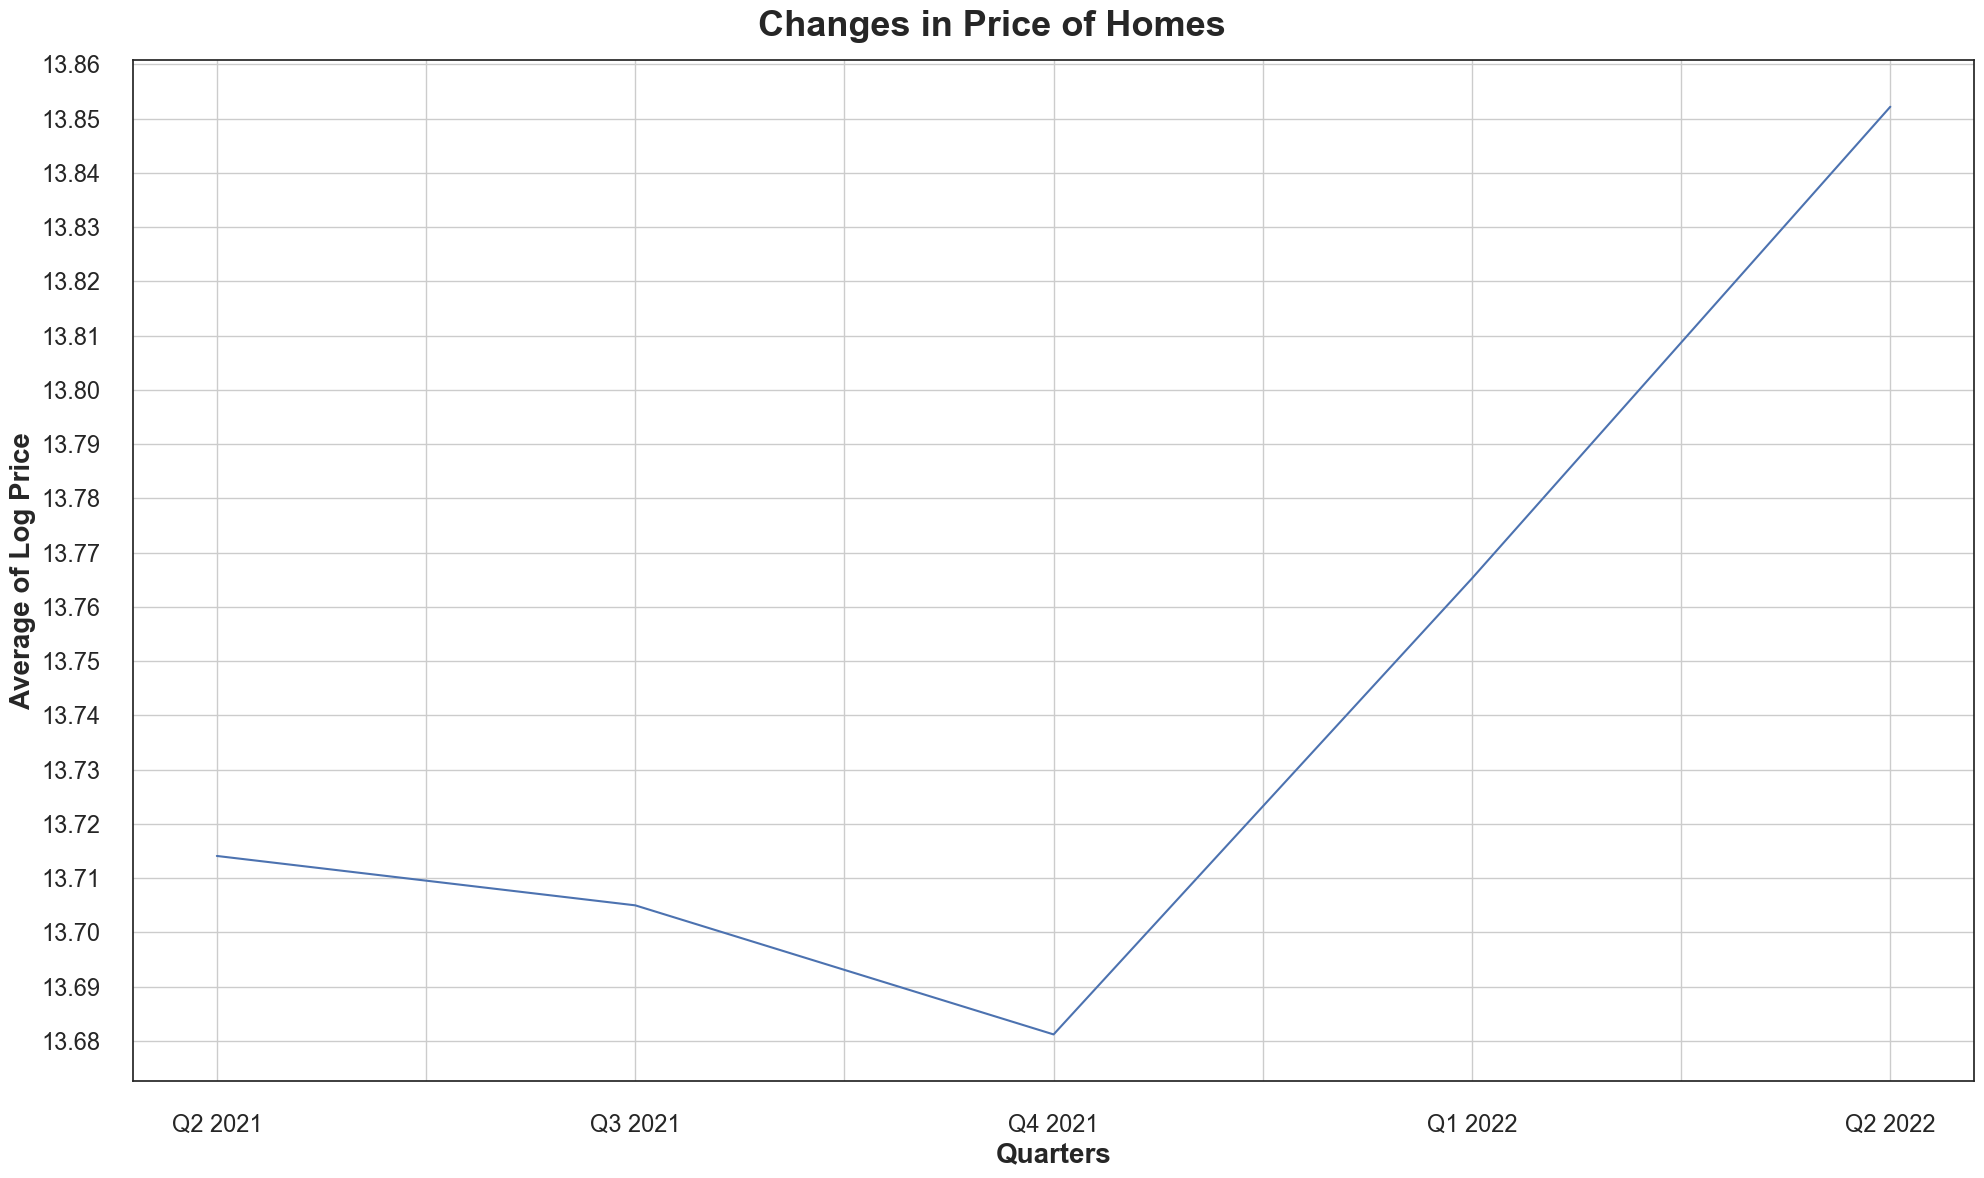

In [21]:
fig, ax = plt.subplots(figsize=(20,12), dpi=100)

quarter_df.plot.line(x="Quarters", y="Average Log(Price)", ax=ax)

ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.tick_params('both', length=20, width=2, which='major')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Changes in Price of Homes", fontweight='bold', fontsize=26)
ax.set_xlabel("Quarters", fontsize=20, fontweight='bold')
ax.set_ylabel("Average of Log Price", fontsize=20, fontweight='bold')
ax.get_legend().remove()
plt.grid()

plt.tight_layout();

The graph does show that the housing market did decrease towards the end of 2021. This graph may be useful in determining when to invest or sell properties. Further investigation can be made to determine what is actually causing the increase or decrease in price.

Because the log of the price returns a low p-value and is normally distributed, we will create a new column, `log_price` and work with the that column instead of the `price` column for the rest of the project. We will add a new column, `log_price`, to each of the fiscal quarters dataframes.

In [22]:
df['log_price'] = np.log(df["price"])

q2_2021 = df.loc[(df["date"] >= "2021-04-01") & (df["date"] <= "2021-06-30")]
q3_2021 = df.loc[(df["date"] >= "2021-07-01") & (df["date"] <= "2021-09-30")]
q4_2021 = df.loc[(df["date"] >= "2021-10-01") & (df["date"] <= "2021-12-31")]
q1_2022 = df.loc[(df["date"] >= "2022-01-01") & (df["date"] <= "2022-03-31")]
q2_2022 = df.loc[(df["date"] >= "2022-04-01") & (df["date"] <= "2022-06-30")]

#This method was used because using q2_2021['log_price'] = np.log(q2_2021["price"]) returned a 'SettingWithCopyWarning'.

# Plotting the price against square feet of homes with a specific number of rooms
As we have seen from `df.corr()`, `price` had the largest correlation value with `sqft_living` (`0.616590`). A linear regression can be made by setting `X_baseline` as `sqft_living` and `y` as `price`. However, we can dive deeper and observe how prices change according to the square footage given a certain number of `total rooms`.

First, we can create a function where the input is the dataframe and returns a table with `total rooms`, `count`, and `correlation`:

In [23]:
def total_rooms(dataframe):
    #create a dataframe that contains how many times a certain value in 'total rooms' appears
    count = dataframe["total rooms"].value_counts(ascending=False)
    
    #a new dataframe that has two columns: 'total rooms' and 'count'
    df = pd.DataFrame({'total rooms':count.index, 'count':count.values})
    
    #adding a new column that contains correlation values between the 'log_price' and `sqft_living`
    corr = []
    rooms = dataframe.groupby(dataframe["total rooms"])
    for i in list(df["total rooms"]):
        x_rooms = rooms.get_group(i)
        corr.append(x_rooms.corr()["log_price"]["sqft_living"])
    df["correlation"] = corr
    return df

By running the function for each quarter, we can see `sqft_living` affects the `price` given a `total room`.

In [24]:
total_rooms(q2_2021)

,total rooms,count,correlation
0,6.5,409,0.487400
1,5.0,349,0.286924
2,5.5,333,0.462647
3,6.0,222,0.454278
4,4.0,203,0.324307
5,7.0,188,0.411756
6,3.0,146,0.198795
7,7.5,135,0.474683
8,8.0,105,0.577026
9,4.5,94,0.489921


In [25]:
total_rooms(q3_2021)

,total rooms,count,correlation
0,6.5,1370,0.467964
1,5.5,1325,0.485421
2,5.0,1307,0.372934
3,6.0,859,0.454583
4,4.0,837,0.394354
5,7.0,730,0.439814
6,3.0,530,0.204273
7,7.5,509,0.574035
8,4.5,420,0.405424
9,8.0,414,0.497690


In [26]:
total_rooms(q4_2021)

,total rooms,count,correlation
0,5.0,1082,0.356452
1,6.5,933,0.474159
2,5.5,922,0.453108
3,4.0,796,0.326872
4,6.0,636,0.422979
5,7.0,569,0.461031
6,3.0,446,0.201812
7,4.5,345,0.345767
8,7.5,339,0.528796
9,8.0,311,0.507601


In [27]:
total_rooms(q1_2022)

,total rooms,count,correlation
0,5.0,827,0.294394
1,5.5,753,0.456490
2,6.5,676,0.520847
3,4.0,555,0.274769
4,6.0,476,0.316194
5,3.0,389,0.251922
6,7.0,375,0.503446
7,4.5,283,0.342000
8,7.5,239,0.568249
9,8.0,195,0.498339


In [28]:
total_rooms(q2_2022)

,total rooms,count,correlation
0,5.0,837,0.344186
1,6.5,773,0.509644
2,5.5,769,0.486224
3,4.0,542,0.277589
4,6.0,472,0.367791
5,7.0,416,0.514092
6,3.0,357,0.217805
7,7.5,256,0.549703
8,4.5,246,0.458442
9,8.0,236,0.608095


### Creating a linear model of Average log price vs. Square feet given a specific `total rooms`
We want to create a model where it takes in `sqft_living` as the input and the output would be the natural log of the price.

First we can group the dataframes by `total rooms`.

In [29]:
q2_2021_rooms = q2_2021.groupby(q2_2021["total rooms"])
q3_2021_rooms = q3_2021.groupby(q3_2021["total rooms"])
q4_2021_rooms = q4_2021.groupby(q4_2021["total rooms"])
q1_2022_rooms = q1_2022.groupby(q1_2022["total rooms"])
q2_2022_rooms = q2_2022.groupby(q2_2022["total rooms"])

Next we can select the dataframe that only has `total rooms` of 8.

In [30]:
num_rooms = 8.0
q2_2021_x_rooms = q2_2021_rooms.get_group(num_rooms)
q3_2021_x_rooms = q3_2021_rooms.get_group(num_rooms)
q4_2021_x_rooms = q4_2021_rooms.get_group(num_rooms)
q1_2022_x_rooms = q1_2022_rooms.get_group(num_rooms)
q2_2022_x_rooms = q2_2022_rooms.get_group(num_rooms)

A function with the dataset as the input, and the return being the results of the model and mean square error which tells us how close the model is to the data.

In [31]:
def regression(dataframe):
    #set the y equal to the 'log_price'
    y = dataframe["log_price"]
    
    #the X_baseline is 'sqft_living'
    X_baseline = dataframe[["sqft_living"]]
    
    #create the linear model and store results in baseline_results
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    
    #return the summary of results so we can observe the r-squared value
    #additionly return the mean squared error of the model
    return print(baseline_results.summary(),'\n',baseline_results.params), mean_squared_error(y, baseline_results.predict(sm.add_constant(X_baseline)), squared=False)

This function will allow us to create a linear model from the provided dataset. The output will then be used in the next function in order to plot the best-fit line.

In [32]:
def results(dataframe):
    x = dataframe[["sqft_living"]]
    y = dataframe[["log_price"]]
    
    #the linear model that will be used for our visual plots
    model = sm.OLS(endog=y, exog=sm.add_constant(x))
    results=model.fit()
    return results

This function will allow us to create a scatterplot and the linear regression model.

In [33]:
#removes the error with color of data points when creating the dataframe 
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def graph(dataframe):
    fig, ax = plt.subplots(figsize=(20,12), dpi=100)
    
    dataframe.plot.scatter(x='sqft_living', y='log_price', ax=ax)
    
    #plot the linear model using the function results(dataframe)
    sm.graphics.abline_plot(model_results=results(dataframe), ax=ax)

    ax.set_facecolor("white")
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    ax.set_xlabel("Square Feet", fontsize=20, fontweight='bold')
    ax.set_ylabel("Log of Price", fontsize=20, fontweight='bold')

    plt.tight_layout();

In [34]:
regression(q2_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     51.41
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           1.17e-10
Time:                        14:47:33   Log-Likelihood:                -47.637
No. Observations:                 105   AIC:                             99.27
Df Residuals:                     103   BIC:                             104.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8622      0.158     81.477      

(None, 0.38088552490687794)

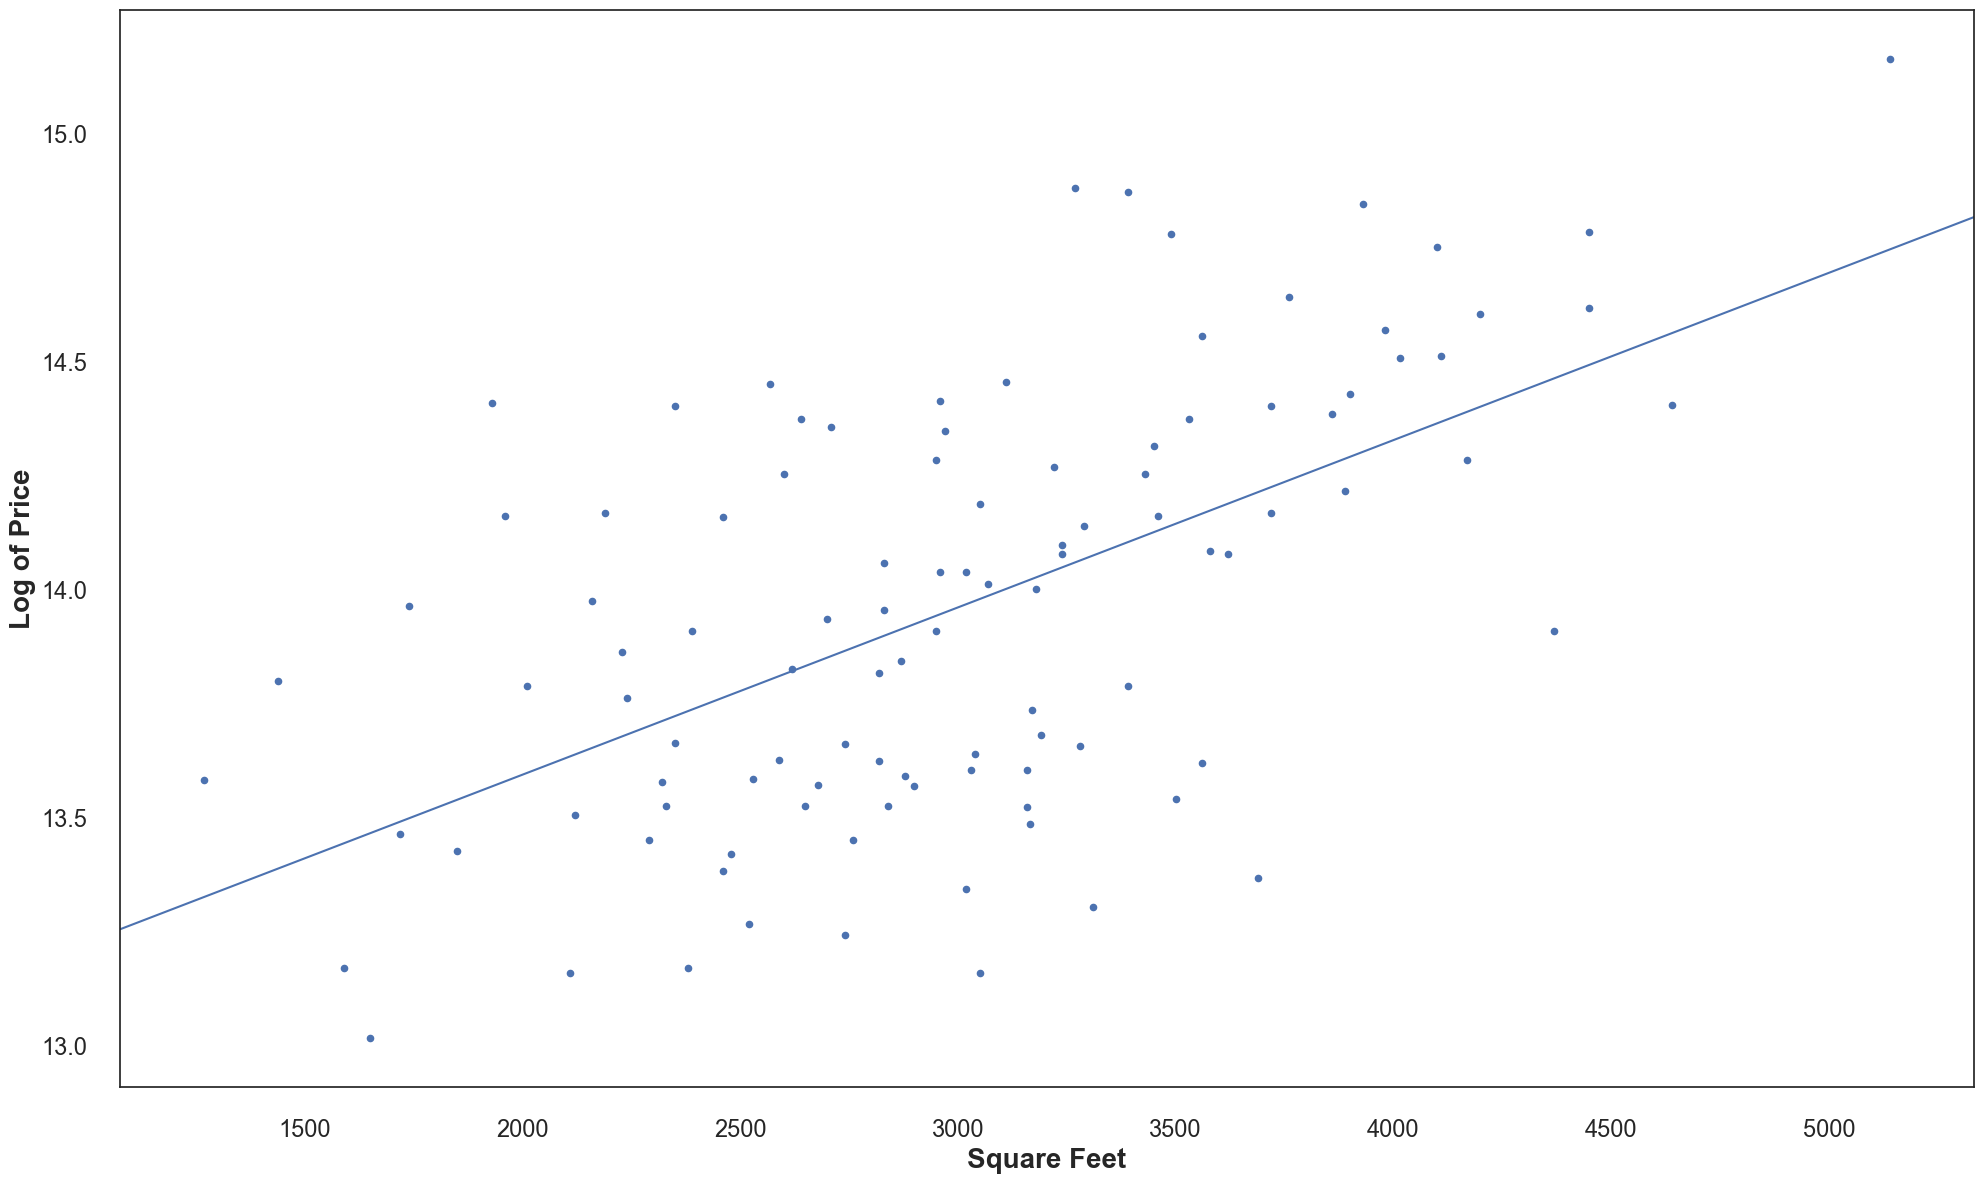

In [35]:
graph(q2_2021_x_rooms)

In [36]:
regression(q3_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     135.7
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           2.70e-27
Time:                        14:47:33   Log-Likelihood:                -260.03
No. Observations:                 414   AIC:                             524.1
Df Residuals:                     412   BIC:                             532.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8819      0.098    131.202      

(None, 0.453455784091846)

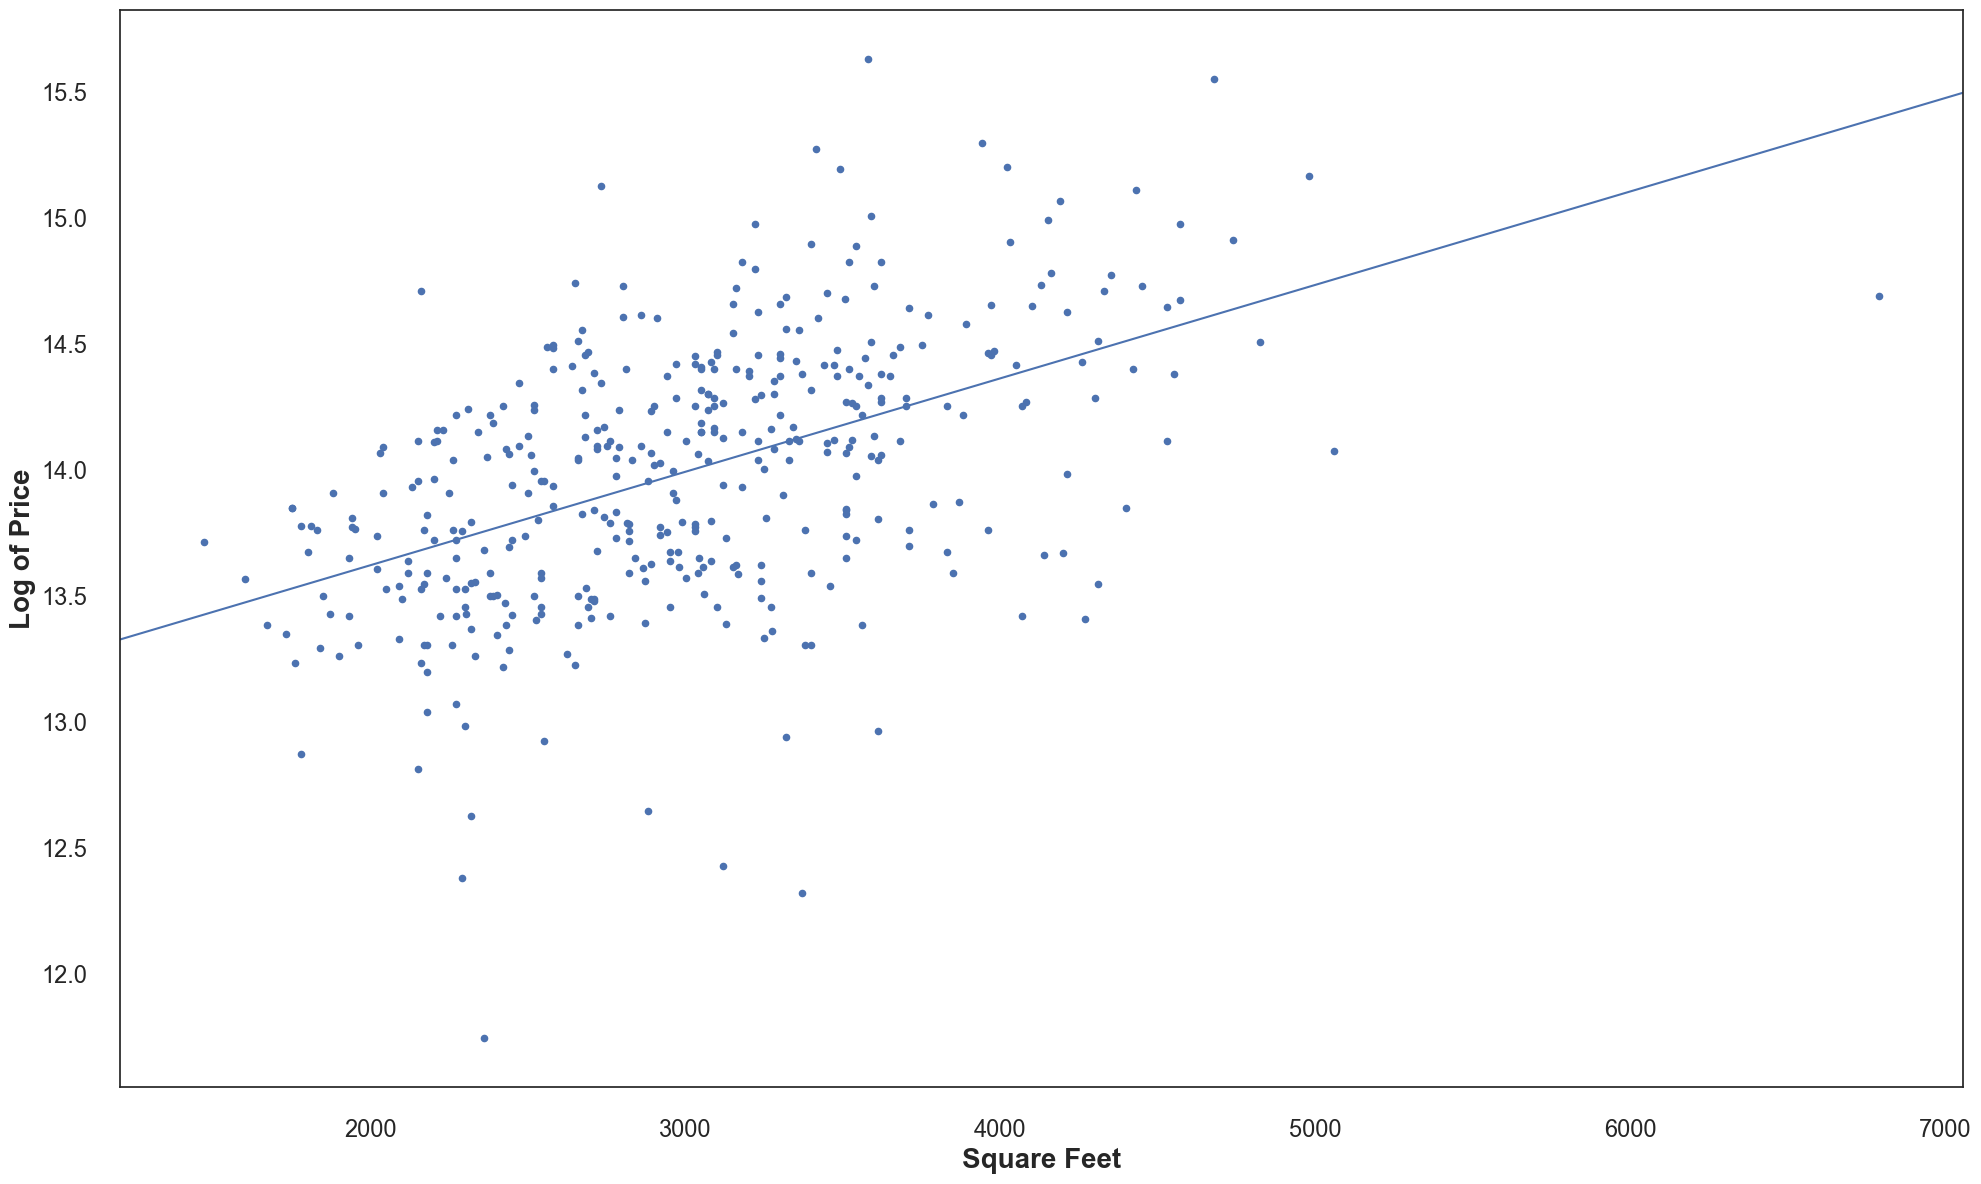

In [37]:
graph(q3_2021_x_rooms)

In [38]:
regression(q4_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     107.3
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           9.02e-22
Time:                        14:47:34   Log-Likelihood:                -216.31
No. Observations:                 311   AIC:                             436.6
Df Residuals:                     309   BIC:                             444.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8491      0.112    114.743      

(None, 0.48509343642349206)

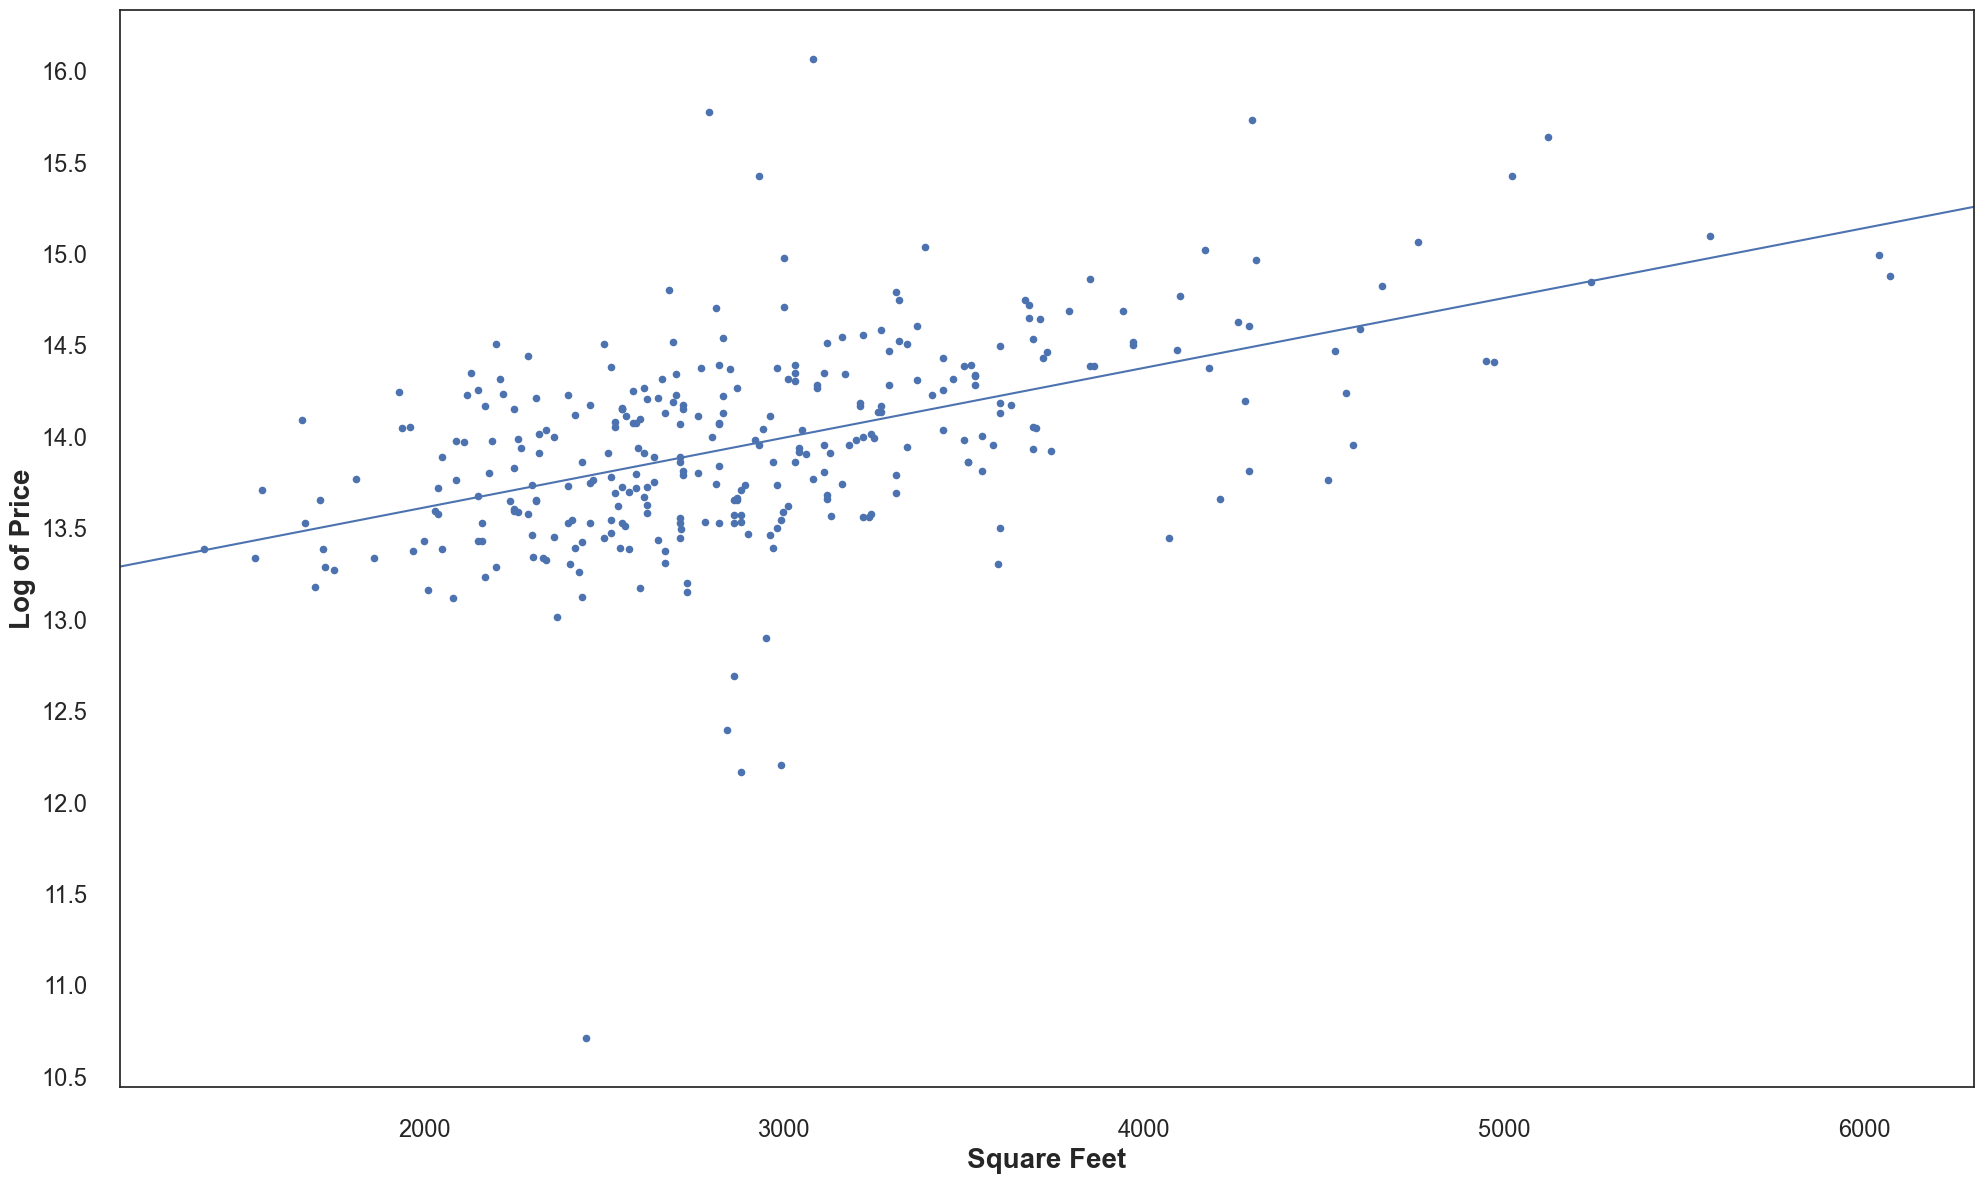

In [39]:
graph(q4_2021_x_rooms)

In [40]:
regression(q1_2022_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     63.77
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           1.23e-13
Time:                        14:47:35   Log-Likelihood:                -129.62
No. Observations:                 195   AIC:                             263.2
Df Residuals:                     193   BIC:                             269.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8718      0.149     86.349      

(None, 0.47036572960635903)

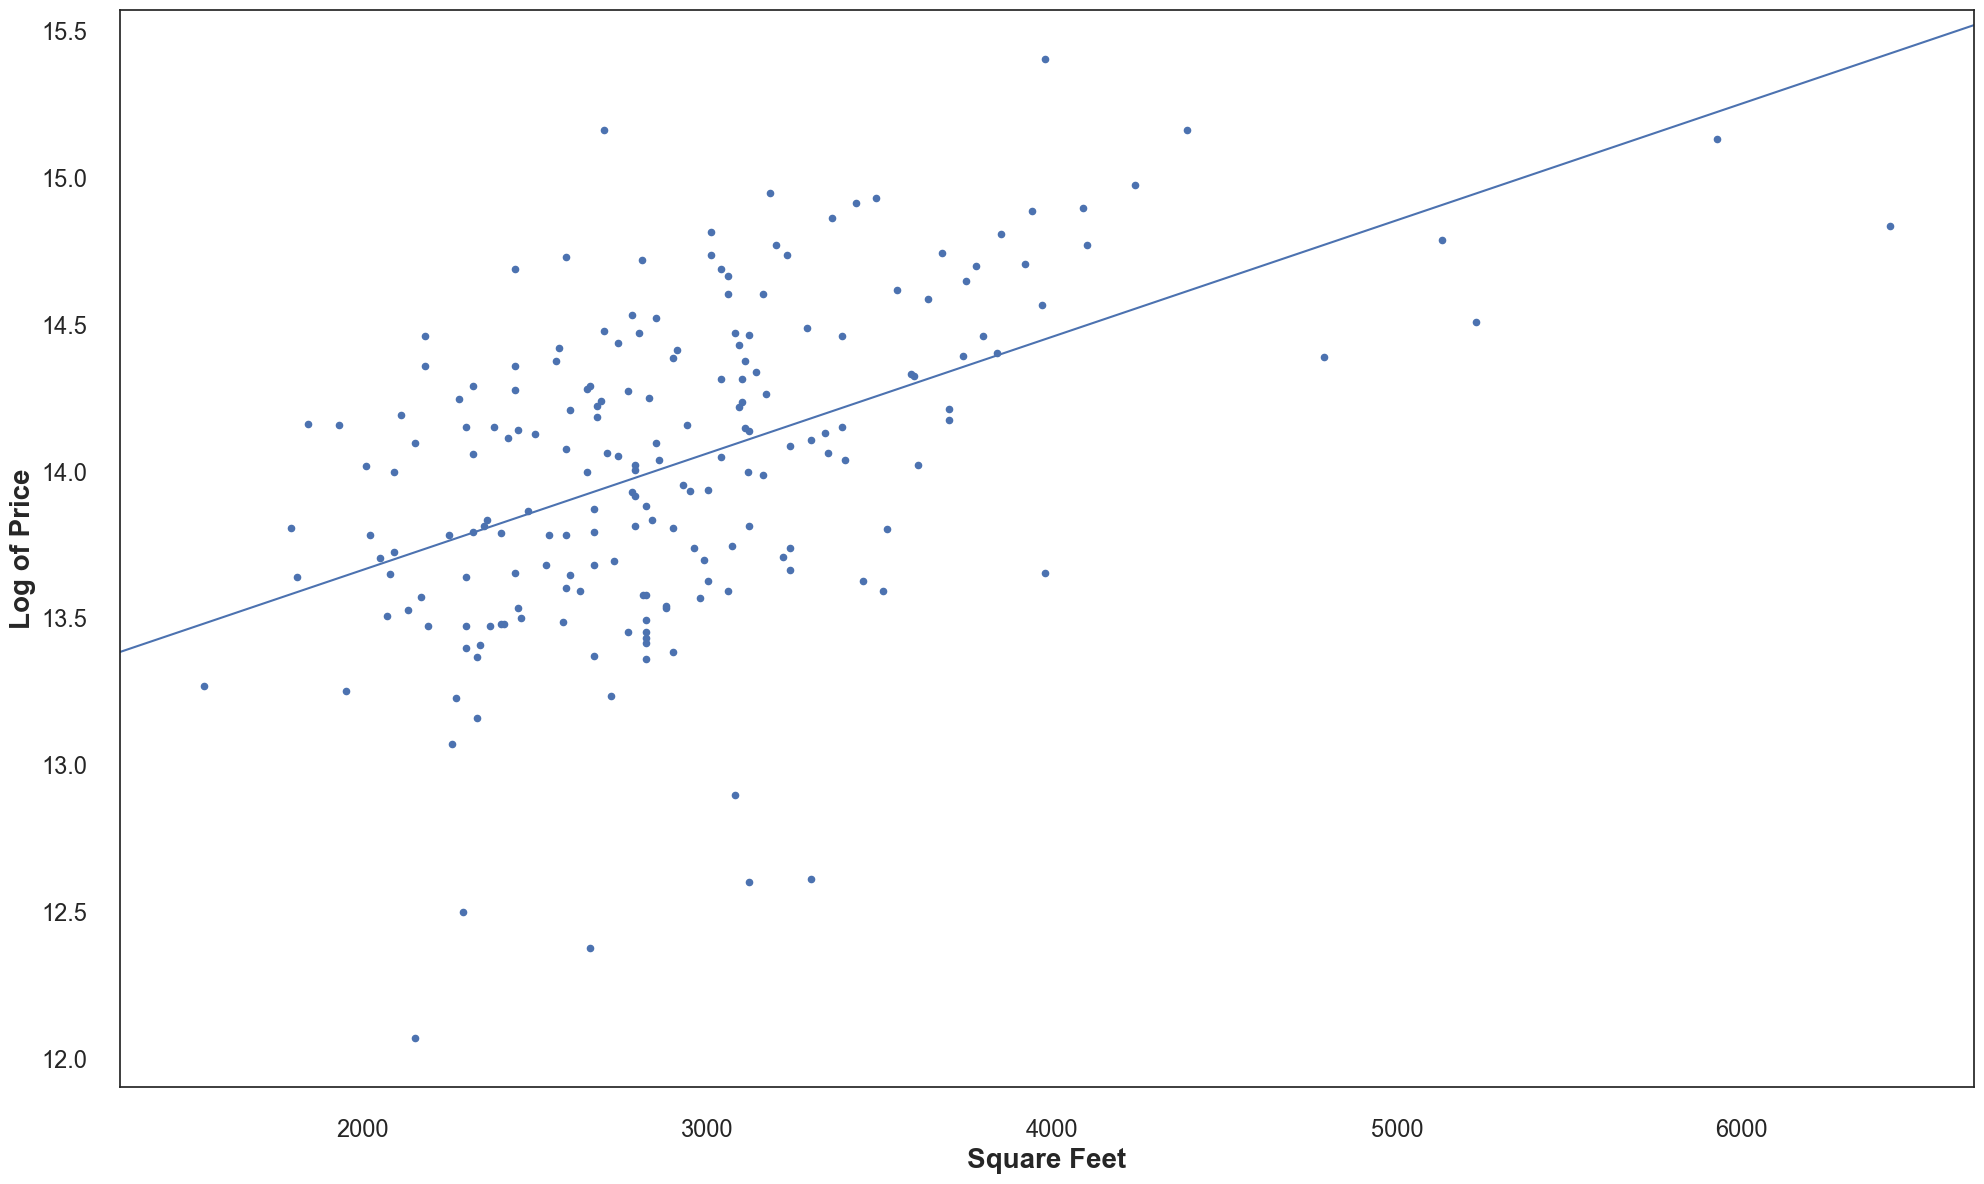

In [41]:
graph(q1_2022_x_rooms)

In [42]:
regression(q2_2022_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     137.3
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           2.95e-25
Time:                        14:47:35   Log-Likelihood:                -130.13
No. Observations:                 236   AIC:                             264.3
Df Residuals:                     234   BIC:                             271.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.7307      0.122    104.188      

(None, 0.41998231784425855)

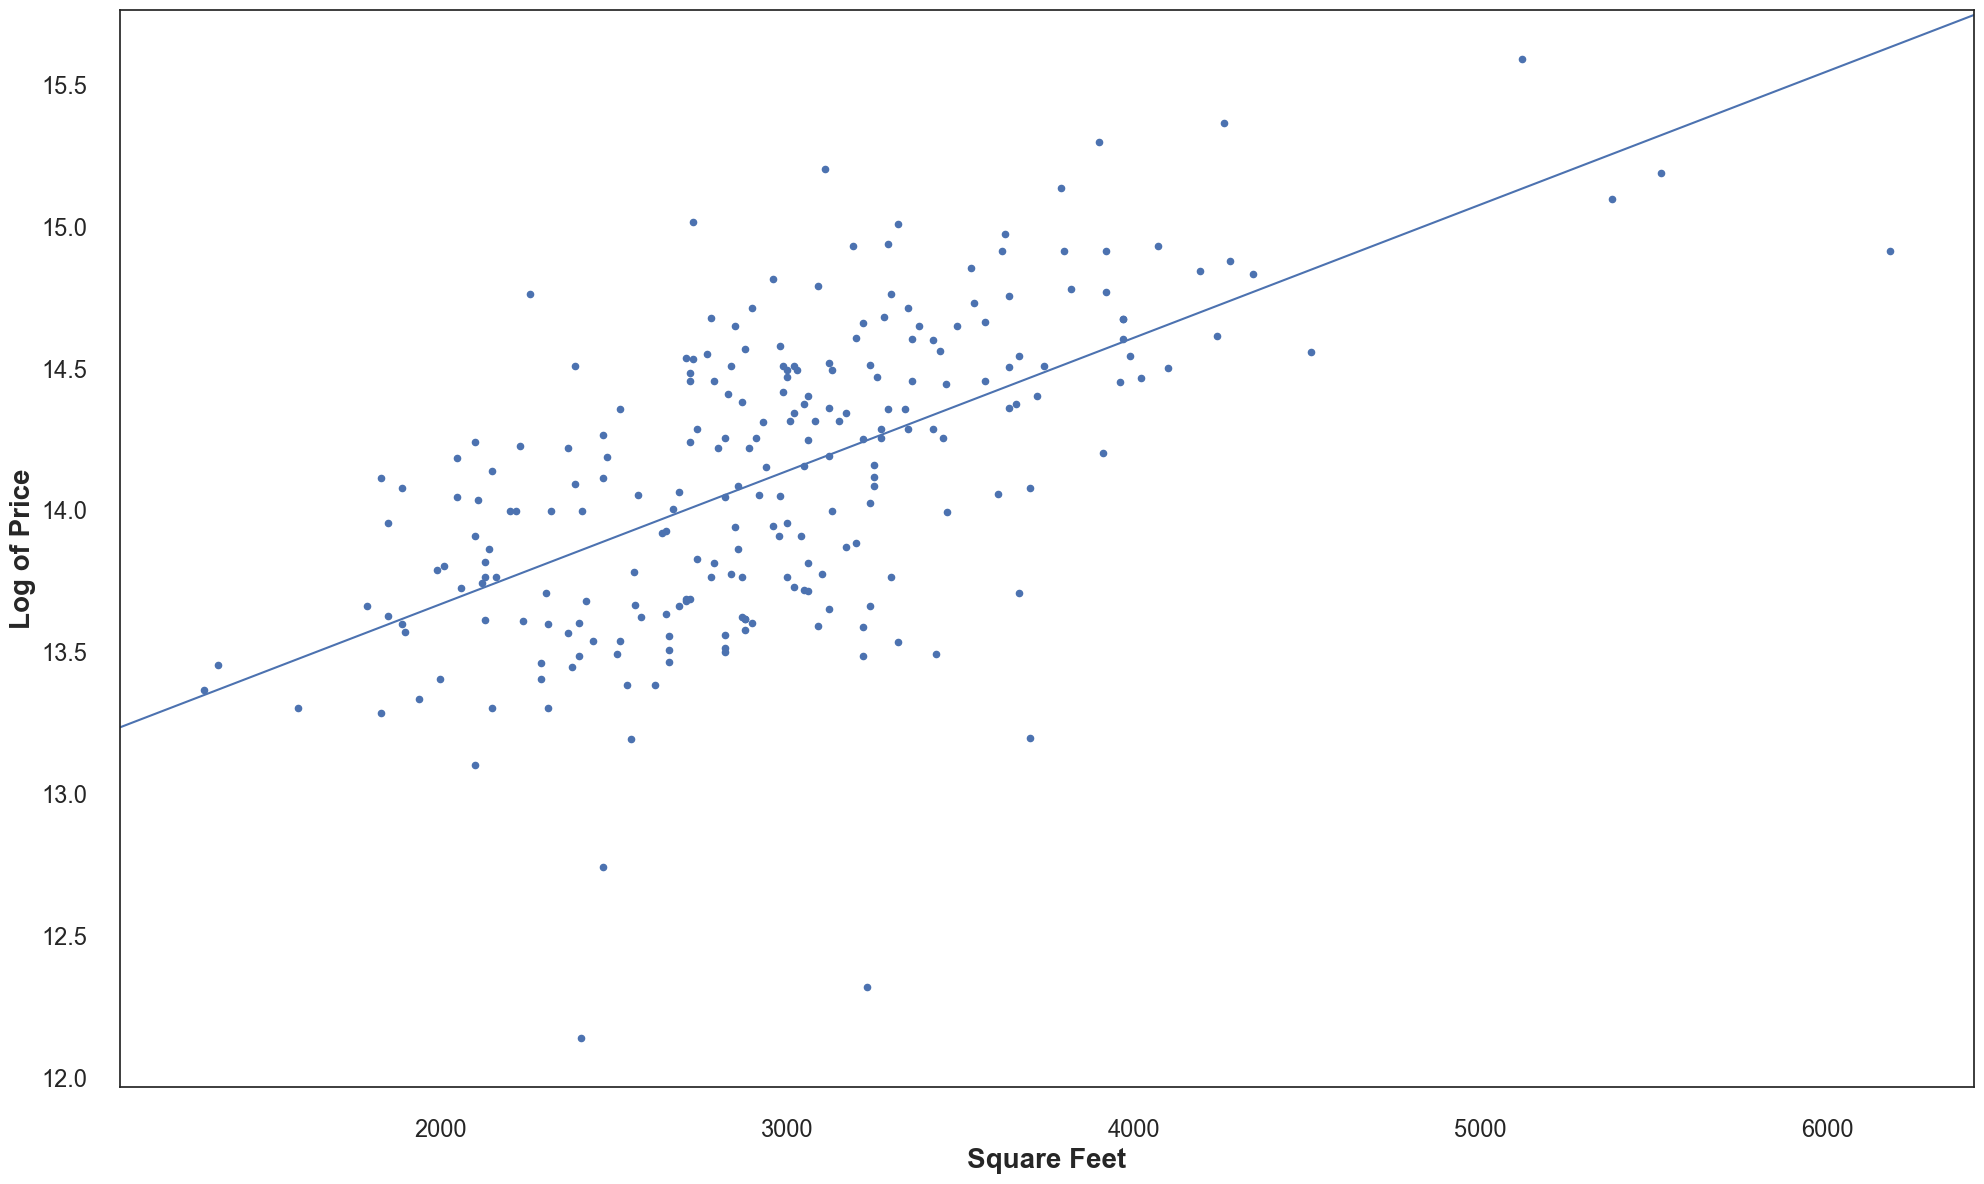

In [43]:
graph(q2_2022_x_rooms)

### Regression results

Quarters |Adj. R-Squared |Constant Coef. (P-Value) |sqft_living Coef. (P-Value) |Mean-Squared Error
:-------:|:-------------:|:-----------------------:|:--------------------------:|:----------------:
Q2 2021  |0.326          |12.86 (0.000)            |0.000367 (0.000)              |0.381
Q3 2021  |0.246          |12.88 (0.000)            |0.000371 (0.000)              |0.453
Q4 2021  |0.255          |12.85 (0.000)            |0.000382 (0.000)              |0.485
Q1 2022  |0.248          |12.87 (0.000)            |0.000397 (0.000)              |0.470
Q2 2022  |0.367          |12.73 (0.000)            |0.000469 (0.000)              |0.420

It seems the linear model of Q2 2021 had the lowest MSE followed by Q2 2022. Although the MSE are low, the models have very low r-squared values. This means that the linear model can explain less than half of the variance in `log_price`. Despite low r-squared values we can create this equation to predict prices:
### $$ price = e^{constant ~ coef. ~ + ~ sqft. ~ living ~ coef. ~ x}  $$

Another problem with the results is that it seems like the coefficients for `sqft_living` are similar. We can plot the linear models against each other to see how different the coefficients are.

Fortunately, the p-value for all the coefficients are less than 0.05 meaning these values are statistically significant and not due to chance.

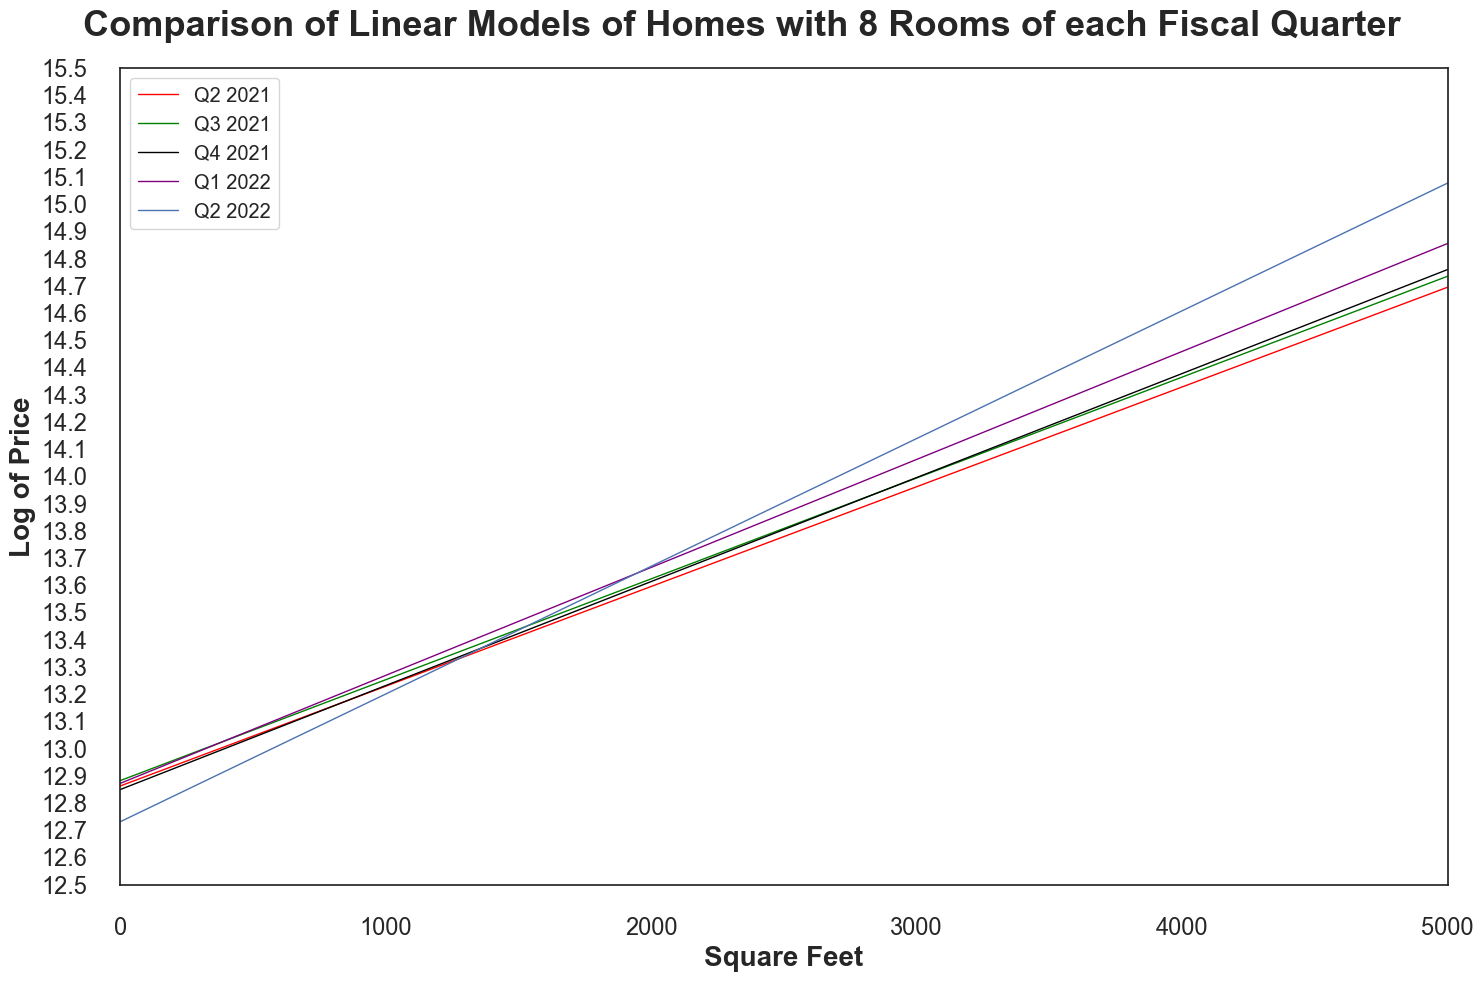

In [44]:
fig, ax = plt.subplots(figsize=(15,10), dpi=100)

#plot all the linear models to compare the differences in slopes or rate of change
sm.graphics.abline_plot(model_results=results(q2_2021_x_rooms), ax=ax, color='red', linewidth=1, label="Q2 2021")
sm.graphics.abline_plot(model_results=results(q3_2021_x_rooms), ax=ax, color='green', linewidth=1, label="Q3 2021")
sm.graphics.abline_plot(model_results=results(q4_2021_x_rooms), ax=ax, color='black', linewidth=1, label="Q4 2021")
sm.graphics.abline_plot(model_results=results(q1_2022_x_rooms), ax=ax, color='purple', linewidth=1, label="Q1 2022")
sm.graphics.abline_plot(model_results=results(q2_2022_x_rooms), ax=ax, linewidth=1, label="Q2 2022")

ax = plt.gca()
ax.set_xlim([0, 5000])
ax.set_ylim([12.5, 15.5])
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparison of Linear Models of Homes with 8 Rooms of each Fiscal Quarter", fontweight='bold', fontsize=26)
ax.set_xlabel("Square Feet", fontsize=20, fontweight='bold')
ax.set_ylabel("Log of Price", fontsize=20, fontweight='bold')

ax.legend(fontsize='large')

plt.tight_layout();

We can see that the __Q2 2022__ slope is the greatest followed by __Q1 2022__ slope. A higher slope indicates greater positive changes in price as square feet increases. This confirms our alternative hypothesis that price changes through time.

Despite creating a model of 8 room homes, the r-squared value it too low. Therefore the current linear model may not be accurate enough to make a prediction. There may be other variables that are causing low r-squared values. We can separate the homes according to their categorical values (i.e. 'condition', 'grade', or 'waterfront') in hopes of finding a more significant relationship.

# Categorical variables

Categorical data is another way to measure a home's value. These datasets come with numerous categorical columns that contain strings for values. We can investigate the values of the categorical columns with a for loop and use dummy values to assign integer values to each categorical column.

We will be using the data in `q2_2022_x_rooms` as it provides us with the most recent data. And as stated before, prices of homes change according to time. Therefore in order to make an accurate prediction, the most recent data available should be used.

In [45]:
categories = q2_2022_x_rooms.select_dtypes("object")

for col in categories:
    print(q2_2022_x_rooms[col].value_counts(), "\n")

NO     232
YES      4
Name: waterfront, dtype: int64 

NO     226
YES     10
Name: greenbelt, dtype: int64 

NO     204
YES     32
Name: nuisance, dtype: int64 

NONE         191
AVERAGE       23
GOOD          12
EXCELLENT      6
FAIR           4
Name: view, dtype: int64 

Average      156
Good          53
Very Good     26
Fair           1
Name: condition, dtype: int64 

8 Good           91
7 Average        64
9 Better         50
10 Very Good     21
11 Excellent      7
6 Low Average     3
Name: grade, dtype: int64 

Gas            199
Electricity     24
Oil             12
Other            1
Name: heat_source, dtype: int64 

PUBLIC     215
PRIVATE     21
Name: sewer_system, dtype: int64 

3903 Northeast 103rd Street, Seattle, Washington 98125, United States         1
10706 4th Avenue South, Seattle, Washington 98168, United States              1
8205 South 123rd Place, Seattle, Washington 98178, United States              1
7110 149th Avenue Northeast, Redmond, Washington 98052, United 

This for loop provides us with the values and number of occurences in the category. We see that 232 homes do not have waterfronts while 4 of homes do. By only looking at homes that do not have waterfronts, greenbelts, or nuisance, we can then see how categories like `view`, `condition`, and `grade` affects the prices of homes.

In [46]:
no_waterfront = q2_2022_x_rooms.loc[q2_2022_x_rooms['waterfront'].str.contains('NO')]
no_greenbelt = no_waterfront.loc[no_waterfront['greenbelt'].str.contains('NO')]
no_nuisance = no_greenbelt.loc[no_greenbelt['nuisance'].str.contains('NO')]

This function will allow us to input the dataframe and any categorical column that we wish to observe. In return, a dataframe with dummy values will be made.

In [47]:
def category_corr_df(dataframe, cat_col):
    x = dataframe[["sqft_living"]]
    y = dataframe[["log_price"]]
    
    #create dummy variables
    X_iterated = dataframe[["sqft_living", cat_col]]
    X_iterated = pd.get_dummies(X_iterated, columns=[cat_col])
    return X_iterated

Similar to the `regression(dataframe)` function, this function will have the same input but will also include the dataframe containing the dummy values created from the `category_corr_df` function (`x_it`). It will return results of the linear model along with the mean-squared error.

In [48]:
def cat_regression_results(dataframe, x_it):
    y = dataframe[["log_price"]]
    iterated_model = sm.OLS(y, sm.add_constant(x_it))
    iterated_results = iterated_model.fit()
    return print(iterated_results.summary()), mean_squared_error(y, iterated_results.predict(sm.add_constant(X_iterated)), squared=False)

### Seeing how different values of `view` affects the price
In order to observe how the `view` affects the prices of homes, we must keep the `condition` and `grade` columns constant. We can make a new dataframe that contains the same values for these columns except the `view` column. In order to retain as much values as we can, we can look back at the value counts of each value. For this particular dataset, we can filter the dataframe so that it only contains `Average` for `condition` and `8 Good` for `grade`.

In [49]:
view_df = no_nuisance.loc[no_nuisance.condition=="Average"]
view_df = view_df.loc[view_df.grade=="8 Good"]

Now that the dataframe only contains similar values except for `view`, we can input the dataframe along with the categorical column `view` into their corresponding function.

In [50]:
#input view_df and 'view' into category_corr_df()
X_iterated = category_corr_df(view_df, "view")

#obtain the results by inputing view_df and X_iterated into cat_regression_results()
cat_regression_results(view_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     5.000
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           0.000940
Time:                        14:47:38   Log-Likelihood:                -23.749
No. Observations:                  53   AIC:                             59.50
Df Residuals:                      47   BIC:                             71.32
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.9836      0.343     32.

(None, 0.3787598708161047)

From the results we can see how each value for `view` can affect the price of a home, given that the `condition` is `Average` and the `grade` is `8 Good`. The adjusted r-squared value, despite being positively correlated, is relatively low, dictating that the view may not be as influentical in calculating the price. However, an equation can still be created by using the coefficients from the results:

### $$ \ln(price) = 10.9836 + 0.0004 x_1 + 1.8776 x_2 + 2.5244 x_3 + 2.8254 x_4 + 2.0674 x_5 + 1.6887 x_6 $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | view of home is average           |
| $x_3$           | view of home is excellent         |
| $x_4$           | view of home is fair              |
| $x_5$           | view of home is good              |
| $x_6$           | view of home is not graded (none) |
|_Mean-squared error_:  $0.3788$<br> |

___

### Seeing how different `condition` affects price
We can follow the same procedure to see how different values in `condition` affects the price. Again we will look back at the value counts to see which `view` and `grade` values to keep constant. In this case, `view` is `NONE` and `grade` is `8 Good`.

In [51]:
#only look a data where the view == 'NONE' and grade == '8 Good'
condition_df = no_nuisance.loc[no_nuisance.view=="NONE"]
condition_df = condition_df.loc[condition_df.grade=="8 Good"]

In [52]:
#Get the regression results (same step as before but slightly different inputs)
X_iterated = category_corr_df(condition_df, "condition")
cat_regression_results(condition_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     7.052
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           0.000355
Time:                        14:47:38   Log-Likelihood:                -33.987
No. Observations:                  69   AIC:                             75.97
Df Residuals:                      65   BIC:                             84.91
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.0098    

(None, 0.395984982204871)

The r-squared value is incredibly low indicating that the price is very weakly correlated to the `condition`. However we can still construct the formula:
### $$ \ln(price) = 10.0098 + 0.0003 x_1 + 3.1548 x_2 + 3.2235 x_3 + 3.6315 x_4 $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | condition of home is average           |
| $x_3$           | condition of home is good         |
| $x_4$           | condition of home is very good              |
|_Mean-squared error_:  $0.3960$<br> |

___

To observe how `grade` affects home prices, we will set `view` to `NONE` and `condition` to `Average`.

In [53]:
#set view == 'NONE' and condition == 'Average'
grade_df = no_nuisance.loc[no_nuisance.view=="NONE"]
grade_df = grade_df.loc[grade_df.condition=="Average"]

In [54]:
#obtain regression results
X_iterated = category_corr_df(grade_df, "grade")
cat_regression_results(grade_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     20.81
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           3.37e-14
Time:                        14:47:38   Log-Likelihood:                -45.222
No. Observations:                 106   AIC:                             102.4
Df Residuals:                     100   BIC:                             118.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.9764      0

(None, 0.3707157746964745)

The r-squared value indicates that the price may somewhat be correlated to the grade of the home.
### $$ \ln(price) = 10.9764 + 0.0004 x_1 + 2.4966 x_2 + 2.5941 x_3 + 1.7681 x_4 + 1.9212 x_5 + 2.1963 x_6 $$

Because we took the natural log of the price, we can rewrite the equation where the output of the equation is the price:
### $$ price = e^{10.9764 + 0.0004 x_1 + 2.4966 x_2 + 2.5941 x_3 + 1.7681 x_4 + 1.9212 x_5 + 2.1963 x_6} $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | grade of home is very good           |
| $x_3$           | grade of home is excellent        |
| $x_4$           | grade of hone is average           |
| $x_5$           | grade of home is good             |
| $x_6$           | grade of home is better         |
|_Mean-squared error_:  $0.3707$<br> |

$x_1$ can be any positive value that can reasonably indicate the square footage whereas $x_2$ to $x_6$ are binary values: 0 or 1. If the `grade` is `very good` $x_2$ = 1 while $x_3$ to $x_6$ = 0.

### Categorical regression results
When comparing the r-squared values, the linear model for `grade` had the highest value of `0.510` meaning the model was able to explain 51% of the variance of the data. Additionally, by limiting the data according to their `grade`, the r-squared improved from `0.370`. The MSE also improved to `0.3707` compared to `0.420` The lower MSE value indicates a linear model better resembles the data.

The highest coefficient for `grade` is `2.59`. This means that homes with a grade of `Excellent` will yield a higher price.

# Conclusion
### Other variables may affect prices
From the data provided we can make multiple conclusions. One of which is that the price of homes seem to fluctuate throughout the year of 2021. This maybe due to the unstablity caused by COVID-19. However, the prices of homes seem to be in an upward trend as of the second quarter of 2022. To further investigate this hypothesis, we can observe the demand of the homes in King County by looking at factors like employment and migration rate of the area. Another factor that may influence the housing market may also be mortgage rates. As mortgage rates increase it may be difficult to purchase a home which may cause consumers to rent property instead.

### Maximizing our profits
#### Square footage of living space
J.P. Morgan can maximize profits by observing the changes in the coefficients of `sqft_living`.
Assuming nothing detrimental happens to the economy, J.P. Morgan can comfortably invest in real estate. For example, if J.P. Morgan purchased an 8 room home with a square footage of 3000 in the second quarter of 2021, the price would have been:
### $$ $1,159,152.86 = e^{12.8622 + 0.000367(3000)} $$
And in the second quarter of 2022, the price is:
### $$ $1,380,146.21 = e^{12.7307 + 0.000469(3000)} $$
We would have profitted around \\$ 200,000 by holding the home for just a year.
#### Grade
Another conclusion we can make is when we specifically look a King County, `view` and `condition` of a home is weakly correlated in determining its price. Therefore, investing in homes because they have a good view or condition may not be the best metric. Instead, we can look at homes with specific a `grade` as it is more predictable; specifically, homes with a grade of `Very Good` or `Excellent`, as it may yield the best investments. Therefore we can use this model to predict a selling/buying price of our homes:
### $$ price = e^{10.9764 + 0.0004 x_1 + 2.4966 x_2 + 2.5941 x_3 + 1.7681 x_4 + 1.9212 x_5 + 2.1963 x_6} $$
To maximize J.P. Morgan's profits we have two routes: buy and sell the houses in the future or buy low grade houses and renovate to a higher grade. For example, if an eight room home with a 3000 square footage and a grade of average is bought, we can expect to spend this much:
### $$ $1,137,678.11 = e^{10.9764 + 0.0004(3000) + 1.7681(1)} $$
By renovating the home to a very good grade, we can sell the house at:
### $$ $2,357,235.28 = e^{10.9764 + 0.0004(3000) + 2.4966(1)} $$
That is a profit of around \\$ 1.2 million without considering the cost of renovations.